Marketing is trying to identify pickup location ids to incentivise passengers in
order to increase the number of trips. 

By using 2020 March to August Yellow
Cabs transactions build a recommendation engine to help marketing identify
these potential location ids on a weekly basis? 

Also define why you think
these areas are potential areas to incentivise according to you?

In [ ]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from pandas.tseries.offsets import Week

import logging, sys
logging.disable(sys.maxsize)
%matplotlib inline


In [9]:
data = pd.read_pickle('../data/full_cleaned_trip_data.pkl')

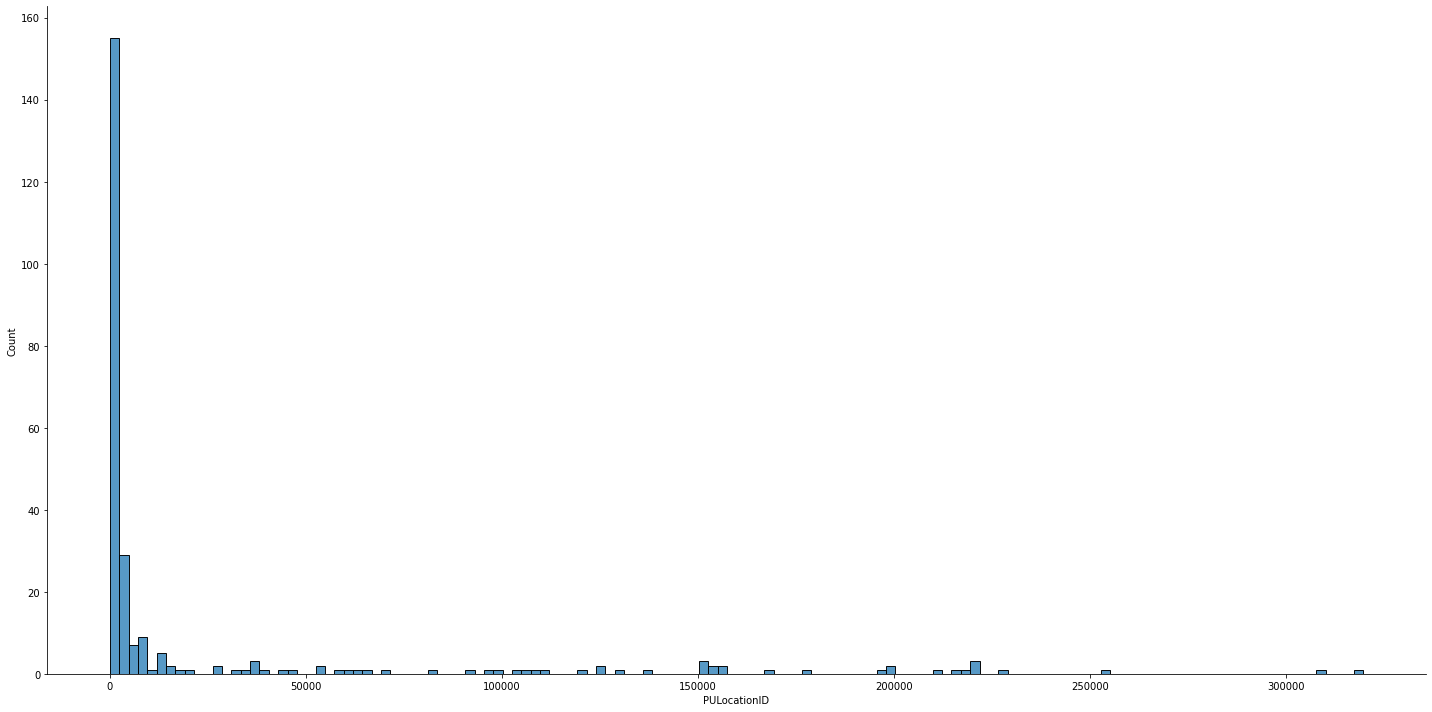

In [10]:
sns.displot(x=data.PULocationID.value_counts(), height=10, aspect=2)

In [83]:
import numpy as np

def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return np.cumsum(x * counts), cusum 

import matplotlib.pyplot as plt

def plot_cdf(pu_freq):
    x, y = ecdf(pu_freq)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    fig, ax = plt.subplots(figsize=(16,10))
    ax = sns.lineplot(x, y, drawstyle='steps-post', linewidth = 2.5)
    plt.axhline(222, c='red', ls='--')
    plt.grid(True)
    trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
    ax.text(0,222, "{:.0f}".format(222), color="red", transform=trans, 
            ha="right", va="center")
    plt.xlabel('Number of taxi rides', fontsize=20)
    plt.ylabel('Number of PU IDs', fontsize=20)
    plt.show()

In [84]:
import matplotlib.transforms as transforms

In [86]:
data.PULocationID.nunique()

262

/home/svujovic/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


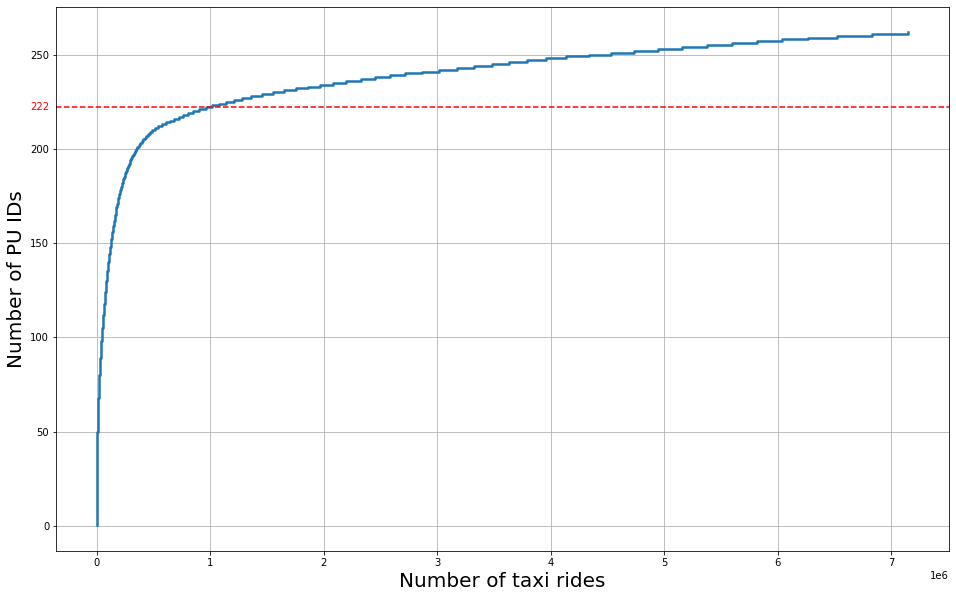

In [173]:
plot_cdf(data.PULocationID.value_counts())

From here, we can see that `222 Locations` (below the red line) generate "just" `100_000_000` rides. Where the `other 40 PU Locations` create the `remaining 6_000_000`.

# How and Where to Incentivise? 

There are 2 simple approaches we could consider to incentivise customers. Either focus on:
* The first 222 locations that are currently less utilized
* On the 40 locations that are generating most of the rides

I would choose the second option, because it would be a safer bet. We know that there is an existing high demand on these locations and it is unlikely that our service is the only one available to the customers.

I would chose this strategy based on the assumption that the real demand is higher than what we can see by counting the rides that actually happened. 

I would additionaly base this on the assumption that our "supply" and infrastructure are on a high level, since most of the rides happen there. 

# Solution

Develop a recommendation system that ranks PU locations based on predicted demand in the upcomming weeks. 

For this, we can leverage the model created for the purpose of the first task. Just this time we would train the model with seperate data for each location.  

The `effect` could be measured after the incentive is applied, to see if the number of rides is significantly higher then the predicted.

In [174]:
location_ids = data.PULocationID.value_counts().head(40).index

### Adding external data

In [175]:
df_covid = pd.read_pickle('../data/covid_daily_processed.pkl')
df_mobility = pd.read_pickle('../data/mobility.pkl')

In [176]:
data['ds'] = data['tpep_pickup_datetime'].dt.date

In [177]:
regressors = [
    'retail_mobility',
    'residential_mobility',
    'transit_mobility',
    'CASE_COUNT_7DAY_AVG',
]

In [178]:
def agg_to_weekly_forecast(forecast):
    forecast['ds_w'] = forecast['ds'].apply(lambda x: x if x.weekday() == 6 else x + Week(weekday=6))
    forecast_w = forecast.groupby('ds_w').agg(yhat=('yhat','sum'),
                                              yhat_lower=('yhat_lower', 'sum'),
                                              yhat_upper=('yhat_upper', 'sum')).reset_index()
    return forecast_w.rename(columns={'ds_w': 'ds'})

def agg_to_weekly_actuals(df_daily):
    df_daily['ds_w'] = df_daily['ds'].apply(lambda x: x if x.weekday() == 6 else x + Week(weekday=6)).copy()
    df_weekly = df_daily.groupby('ds_w').agg(y=('y','sum')).reset_index()
    return df_weekly.rename(columns={'ds_w': 'ds'})


In [179]:
def get_model_forecast(df_train, df_test, regressors, propeth_hparams={}):
    
    if bool(propeth_hparams):
        m = Prophet()
    else:
        m = Prophet(**propeth_hparams)
    
    for reg in regressors:
        m.add_regressor(reg)

    m.add_country_holidays(country_name='US')
    
    m.fit(df_train)  
    forecast = m.predict(df_test)
    
    return (m, forecast)

In [224]:
forecast_df_lst = []

for pu_id in location_ids:
    df = data[data['PULocationID'] == pu_id]
    
    daily_agg_data = df.groupby(['ds']).agg(y=('PULocationID', 'count')).reset_index()
    
    df_daily = daily_agg_data.merge(df_covid).merge(df_mobility)
    df_daily['CASE_COUNT_7DAY_AVG'] = df_daily['CASE_COUNT_7DAY_AVG'].shift(30, fill_value=0)
    df_daily['workplaces_mobility'] = df_daily['workplaces_mobility'].shift(30, fill_value=0)
    df_daily['transit_mobility'] = df_daily['transit_mobility'].shift(30, fill_value=0)
    df_daily['retail_mobility'] = df_daily['retail_mobility'].shift(30, fill_value=0)
    df_daily['grocery_mobility'] = df_daily['grocery_mobility'].shift(30, fill_value=0)
    df_daily['residential_mobility'] = df_daily['residential_mobility'].shift(30, fill_value=0)
    
    df_train = df_daily[df_daily['ds'] < pd.to_datetime('2020-08-01')]
    df_predict = df_daily[df_daily['ds'] >= pd.to_datetime('2020-08-01')]
    
    m, forecast = get_model_forecast(df_train, df_predict, regressors)
    
    forecast_w = agg_to_weekly_forecast(forecast[['ds', 'trend', 'yhat', 'yhat_upper', 'yhat_lower']])
    forecast_w['pu_id'] = pu_id
    forecast_df_lst.append(forecast_w)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/svujovic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/svujovic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

/home/svujovic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/svujovic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
INFO:fbprophet:Disabling yearly seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/svujovic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/svujovic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [242]:
forecasts = pd.concat(forecast_df_lst)
forecasts.head()

,ds,yhat,yhat_lower,yhat_upper,pu_id
0,2020-08-02,1714.257756,-1459.300283,4796.252058,237
1,2020-08-09,8577.028861,-2117.381019,19370.369395,237
2,2020-08-16,9547.079441,-1406.811506,20455.112572,237
3,2020-08-23,10038.178483,-1059.597396,21096.332861,237
4,2020-08-30,10826.756326,-568.447522,22028.572978,237


In [243]:
df_revenue = data.groupby('PULocationID').agg(mean_revenue = ('fare_amount', 'mean')).reset_index()

In [244]:
forecasts = forecasts.merge(df_revenue, left_on='pu_id', right_on='PULocationID')
forecasts['revenue_hat'] = forecasts['yhat'] * forecasts['mean_revenue']
forecasts.head()

,ds,yhat,yhat_lower,yhat_upper,pu_id,PULocationID,mean_revenue,revenue_hat
0,2020-08-02,1714.257756,-1459.300283,4796.252058,237,237,9.083611,15571.650794
1,2020-08-09,8577.028861,-2117.381019,19370.369395,237,237,9.083611,77910.394628
2,2020-08-16,9547.079441,-1406.811506,20455.112572,237,237,9.083611,86721.956857
3,2020-08-23,10038.178483,-1059.597396,21096.332861,237,237,9.083611,91182.909567
4,2020-08-30,10826.756326,-568.447522,22028.572978,237,237,9.083611,98346.044018


In [252]:
forecasts = forecasts.sort_values('revenue_hat', ascending=False)

In [253]:
weekly_recoms = forecasts.groupby('ds').head(10).sort_values('ds')

In [254]:
weekly_recoms.pu_id.value_counts()

237    10
186    10
48     10
141    10
138    10
132    10
236     9
170     9
140     8
263     7
68      3
239     1
79      1
161     1
142     1
Name: pu_id, dtype: int64

In [192]:
import scipy.stats as stats

In [198]:
tau, p_value = stats.kendalltau(weekly_recoms[0:10]['pu_id'], weekly_recoms[10:20]['pu_id'])

In [199]:
tau

0.28888888888888886

In [200]:
p_value

0.2912483465608466

In [257]:
weekly_recoms[0:10].sort_values('revenue_hat', ascending=False)

,ds,yhat,yhat_lower,yhat_upper,pu_id,PULocationID,mean_revenue,revenue_hat
160,2020-08-02,1076.346042,674.874858,1467.149572,132,132,41.370802,44529.298966
290,2020-08-02,1040.610052,261.733082,1829.278378,138,138,28.503765,29661.304872
20,2020-08-02,2209.608736,957.910039,3424.880852,186,186,11.329652,25034.097125
70,2020-08-02,1799.968750,737.540706,2855.301970,48,48,10.593211,19067.448726
60,2020-08-02,1771.348004,906.257757,2616.412297,141,141,9.461435,16759.494817
120,2020-08-02,1630.654134,948.261010,2326.079266,263,263,9.713799,15839.846398
150,2020-08-02,1247.762912,429.666996,2040.319414,68,68,12.533811,15639.224704
0,2020-08-02,1714.257756,-1459.300283,4796.252058,237,237,9.083611,15571.650794
80,2020-08-02,1541.208355,231.998655,2827.119753,142,142,9.958755,15348.516892
90,2020-08-02,1567.390647,605.445629,2520.504163,239,239,9.599616,15046.347874


In [258]:
weekly_recoms[10:20].sort_values('revenue_hat', ascending=False)

,ds,yhat,yhat_lower,yhat_upper,pu_id,PULocationID,mean_revenue,revenue_hat
161,2020-08-09,3468.631164,1896.600854,4983.408378,132,132,41.370802,143500.052981
21,2020-08-09,8666.325718,4224.324737,13285.688283,186,186,11.329652,98186.450955
291,2020-08-09,3195.345254,531.420619,5934.263240,138,138,28.503765,91079.371701
1,2020-08-09,8577.028861,-2117.381019,19370.369395,237,237,9.083611,77910.394628
71,2020-08-09,6860.732515,2944.300106,10619.373217,48,48,10.593211,72677.186998
111,2020-08-09,6158.447290,2781.027878,9682.326917,140,140,11.578571,71306.016659
11,2020-08-09,7526.693867,-2310.926476,17299.507861,236,236,9.422585,70920.909476
61,2020-08-09,7257.398502,4184.864229,10283.553194,141,141,9.461435,68665.407539
51,2020-08-09,6467.909803,1272.207274,11812.347267,170,170,10.599963,68559.605504
121,2020-08-09,6564.251353,4175.095219,8989.171892,263,263,9.713799,63763.817833


In [259]:
weekly_recoms[20:30].sort_values('revenue_hat', ascending=False)

,ds,yhat,yhat_lower,yhat_upper,pu_id,PULocationID,mean_revenue,revenue_hat
162,2020-08-16,3655.856505,1500.871834,5796.192159,132,132,41.370802,151245.715500
22,2020-08-16,9310.030746,4713.598992,14045.781343,186,186,11.329652,105479.404654
292,2020-08-16,3531.532687,769.024680,6281.775293,138,138,28.503765,100661.979432
2,2020-08-16,9547.079441,-1406.811506,20455.112572,237,237,9.083611,86721.956857
12,2020-08-16,8217.563156,-1641.381000,18148.572644,236,236,9.422585,77430.683779
72,2020-08-16,7266.533704,3298.020092,11245.441051,48,48,10.593211,76975.924610
112,2020-08-16,6578.200344,3080.087236,10049.282726,140,140,11.578571,76166.157022
52,2020-08-16,7067.751701,1602.339871,12396.362134,170,170,10.599963,74917.907504
62,2020-08-16,7725.727968,4588.328851,10956.089738,141,141,9.461435,73096.476560
122,2020-08-16,6877.750897,4326.923610,9471.742495,263,263,9.713799,66809.089377


In [261]:
weekly_recoms[80:90].sort_values('revenue_hat', ascending=False)

,ds,yhat,yhat_lower,yhat_upper,pu_id,PULocationID,mean_revenue,revenue_hat
168,2020-09-27,4898.349172,-10342.979771,19800.381281,132,132,41.370802,202648.633594
8,2020-09-27,15071.565463,76.046682,30071.240217,237,237,9.083611,136904.239445
298,2020-09-27,4747.524442,-2928.976033,12780.791087,138,138,28.503765,135322.323239
28,2020-09-27,11823.649290,261.813275,26104.170381,186,186,11.329652,133957.826982
18,2020-09-27,11668.067759,-2170.534345,25604.482650,236,236,9.422585,109943.355198
78,2020-09-27,10081.845664,-2008.488967,22739.972392,48,48,10.593211,106799.118169
68,2020-09-27,10107.204050,711.861438,20374.991534,141,141,9.461435,95628.658808
158,2020-09-27,7514.566381,-2538.398221,17542.439733,68,68,12.533811,94186.155942
198,2020-09-27,8563.469893,-506.191758,17649.728852,79,79,10.929727,93596.390341
58,2020-09-27,8647.344938,-3047.176599,20993.290772,170,170,10.599963,91661.537598
